In [1]:
import pandas as pd
import anndata as ad
from loguru import logger 
import time

import numpy as np
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib

import scimap as sm

Running SCIMAP  2.1.3


In [2]:
sample_id = 997

In [3]:
path_to_quant = f"../data/quantification/{sample_id}_backsub_quantification.csv"
path_to_geojson = f"../data/geojsons/{sample_id}.geojson"
path_to_gates = "../data/phenotyping/20240918_gates.csv"
path_to_phenotype_matrix = "../data/phenotyping/20240905_PhenotypeMatrix_v3.csv"
phenotype_matrix = pd.read_csv(path_to_phenotype_matrix)

In [4]:
custom_colours = {
    "Cancer_cells" : "red",
    "CD4_Tcells" : "peru",
    "CD8_Tcells" : "lawngreen",
    "Macrophages" : "yellow",
    "COL1A1_cells" : "deepskyblue",
    "Vimentin_cells" : "orange",
    "B_cells" : "black",
    "Unknown" : "whitesmoke"
}

In [5]:
adata = utils.read_quant(path_to_quant)
adata

2024-09-18 21:00:39.158 | INFO     | utils:read_quant:24 -  ---- read_quant : version number 1.0.0 ----
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2024-09-18 21:00:40.249 | INFO     | utils:read_quant:43 -  221402 cells and 75 variables
2024-09-18 21:00:40.250 | INFO     | utils:read_quant:44 -  ---- read_quant is done, took 1s  ----


AnnData object with n_obs × n_vars = 221402 × 75
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity'
    var: 'math', 'marker'

2024-09-18 21:00:45.579 | INFO     | utils:filter_by_annotation:161 -  ---- filter_by_annotation : version number 1.2.0 ----
2024-09-18 21:00:45.672 | INFO     | utils:filter_by_annotation:167 - GeoJson loaded, detected: 8 annotations
2024-09-18 21:00:56.665 | INFO     | utils:filter_by_annotation:179 - Labelled cells with annotations if they were found inside
2024-09-18 21:00:56.673 | INFO     | utils:filter_by_annotation:180 - Number of cells not found inside any annotation: 179007


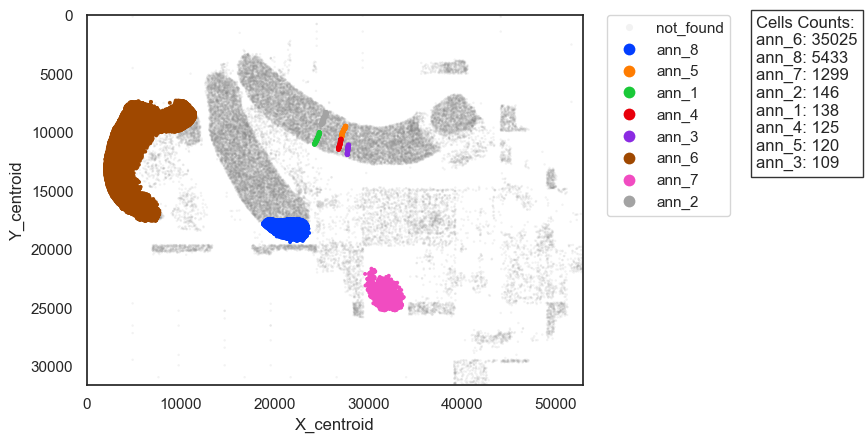

2024-09-18 21:00:57.303 | INFO     | utils:filter_by_annotation:212 -  ---- filter_by_annotation is done, took 11s  ----


In [6]:
adata = utils.filter_by_annotation(adata, path_to_geojson=path_to_geojson)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log10



Threshold for DAPI intensity: 199.53
Threshold for DAPI intensity: 2818.38


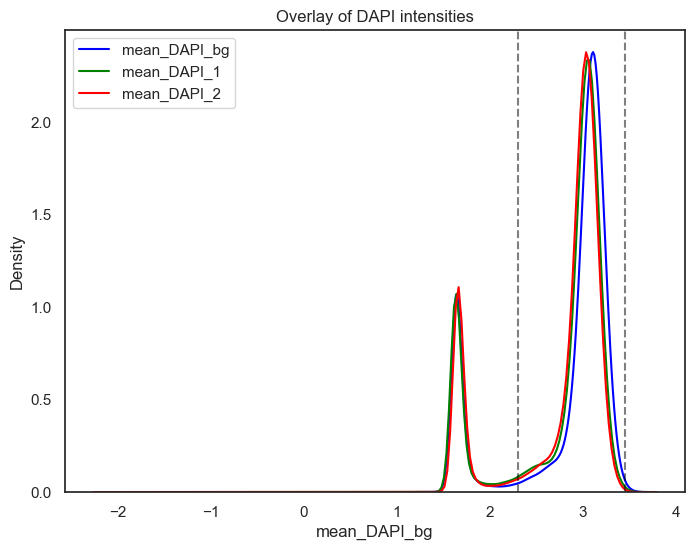

In [7]:
# Plot the density plot for each column
plt.figure(figsize=(8,6))
tmp_df = np.log10(pd.DataFrame(adata.X, columns=adata.var_names))
sns.kdeplot(tmp_df['mean_DAPI_bg'], label='mean_DAPI_bg', color='blue')
sns.kdeplot(tmp_df['mean_DAPI_1'], label='mean_DAPI_1', color='green')
sns.kdeplot(tmp_df['mean_DAPI_2'], label='mean_DAPI_2', color='red')

low_threshold = 2.3
plt.axvline(low_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**low_threshold:.2f}")

high_threshold = 3.45
plt.axvline(high_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**high_threshold:.2f}")

plt.title('Overlay of DAPI intensities')
plt.legend()
plt.show()

2024-09-18 21:01:16.778 | INFO     | utils:filter_by_abs_value:218 -  ---- filter_by_abs_value : version number 1.0.0 ----
2024-09-18 21:01:16.795 | INFO     | utils:filter_by_abs_value:234 - Number of cells with mean_DAPI_bg above 199: 180512


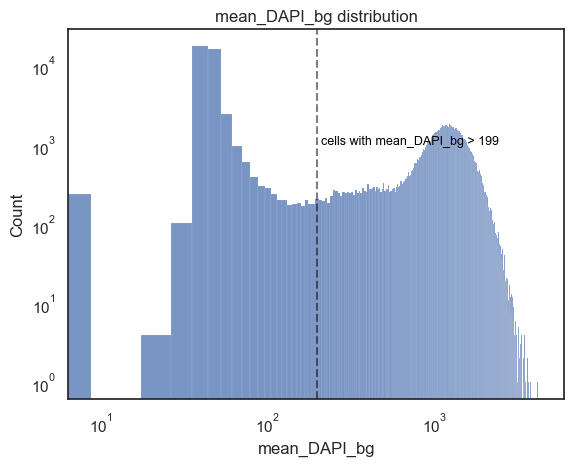

2024-09-18 21:01:17.343 | INFO     | utils:filter_by_abs_value:256 -  ---- filter_by_abs_value is done, took 0s  ----
2024-09-18 21:01:17.343 | INFO     | utils:filter_by_abs_value:218 -  ---- filter_by_abs_value : version number 1.0.0 ----
2024-09-18 21:01:17.352 | INFO     | utils:filter_by_abs_value:239 - Number of cells with mean_DAPI_bg below 2818: 220985


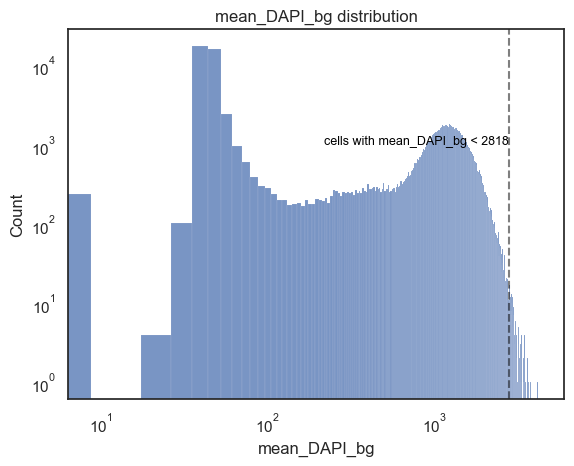

2024-09-18 21:01:17.801 | INFO     | utils:filter_by_abs_value:256 -  ---- filter_by_abs_value is done, took 0s  ----


In [8]:
adata = utils.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=199, direction="above")
adata = utils.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=2818, direction="below")

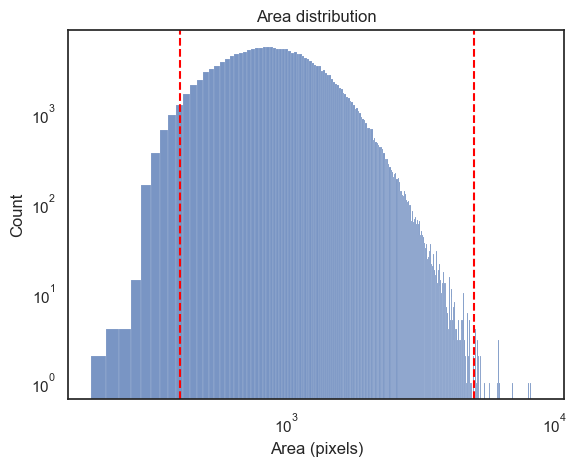

In [9]:
sns.histplot(adata.obs['Area'], bins=350)
plt.yscale('log')
plt.xscale('log')
plt.title('Area distribution')
plt.xlabel('Area (pixels)')
plt.axvline(400, color='red', linestyle='--')
plt.axvline(5000, color='red', linestyle='--')
plt.show()

In [10]:
adata.obs['Area_filter_nottoobig'] = adata.obs['Area'] < 5000
adata.obs['Area_filter_nottoolow'] = adata.obs['Area'] > 400
adata.obs['Area_filter'] = adata.obs['Area_filter_nottoobig'] & adata.obs['Area_filter_nottoolow']

#print stats
print("Number of cells before filtering: ", adata.shape[0])
print("Number of cells filtered out by Area: ", adata.shape[0] - adata.obs['Area_filter'].sum())
print("Percentage of cells filtered out by Area: ", round((adata.shape[0] - adata.obs['Area_filter'].sum())/adata.shape[0]*100, 3), "%")

Number of cells before filtering:  221402
Number of cells filtered out by Area:  2887
Percentage of cells filtered out by Area:  1.304 %


2024-09-18 21:01:56.906 | INFO     | utils:filter_by_ratio:114 -  ---- filter_by_ratio : version number 1.1.0 ----
2024-09-18 21:01:56.924 | INFO     | utils:filter_by_ratio:132 - Number of cells with DAPI ratio < 0.5: 420
2024-09-18 21:01:56.936 | INFO     | utils:filter_by_ratio:133 - Number of cells with DAPI ratio > 1.2: 5196
2024-09-18 21:01:56.948 | INFO     | utils:filter_by_ratio:134 - Number of cells with DAPI ratio between 0.5 and 1.2: 215554
2024-09-18 21:01:56.958 | INFO     | utils:filter_by_ratio:135 - Percentage of cells filtered out: 2.64%


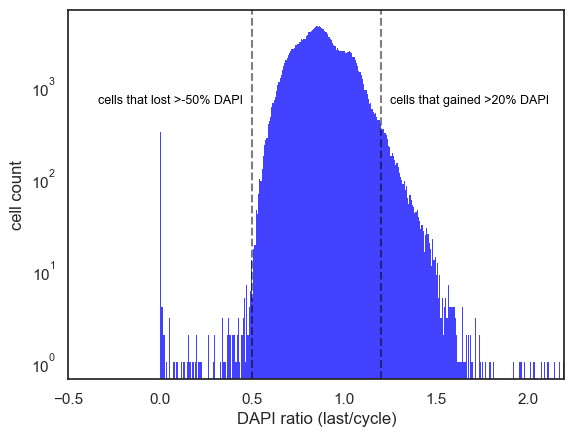

2024-09-18 21:01:58.561 | INFO     | utils:filter_by_ratio:155 -  ---- filter_by_ratio is done, took 1s  ----


In [12]:
adata = utils.filter_by_ratio(
    adata=adata, 
    end_cycle="mean_DAPI_2", 
    start_cycle="mean_DAPI_bg", 
    label="DAPI",
    min_ratio=0.50,
    max_ratio=1.20,
    )

In [13]:
adata = adata[adata.obs['filter_by_ann'].astype(bool) & adata.obs['mean_DAPI_bg_abs_below_value'] & adata.obs['mean_DAPI_bg_abs_above_value'] & adata.obs['Area_filter'] & adata.obs['DAPI_ratio_pass']]

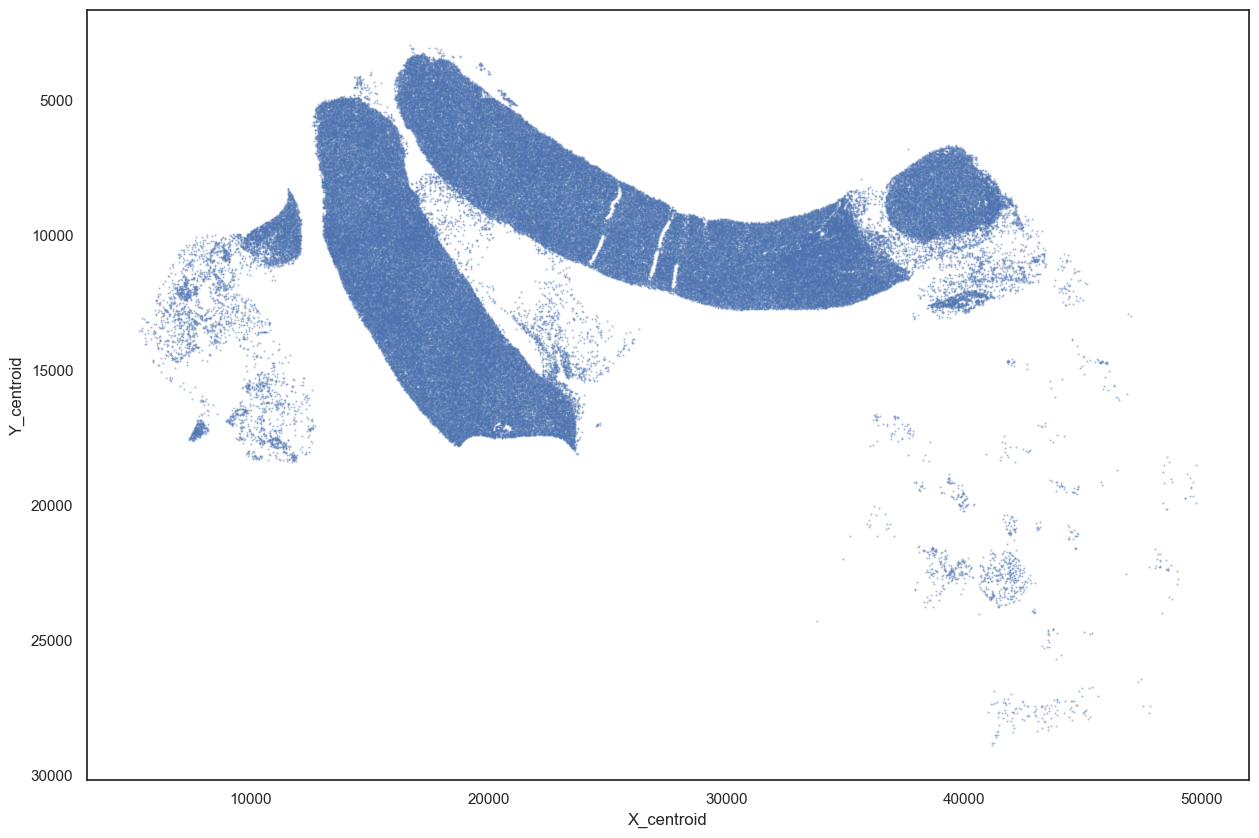

In [14]:
sns.scatterplot(data=adata.obs, x='X_centroid', y='Y_centroid', linewidth=0, s=2, alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.gca().invert_yaxis()
plt.show()

In [15]:
gates = utils.read_gates(path_to_gates)
gates = gates[gates['sample_id']==sample_id]
adata.obs['imageid'] = str(sample_id)
processed_gates = utils.process_gates_for_sm(gates, sample_id=str(sample_id))

2024-09-18 21:03:30.810 | INFO     | utils:read_gates:51 -  ---- read_gates : version number 1.0.0 ----
2024-09-18 21:03:30.815 | INFO     | utils:read_gates:56 -    Filtering out all rows with value 0.0 (assuming not gated)
2024-09-18 21:03:30.816 | INFO     | utils:read_gates:59 -   Found 79 valid gates
2024-09-18 21:03:30.816 | INFO     | utils:read_gates:61 -  ---- read_gates is done, took 0s  ----
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_38650/2216073073.py:3: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

2024-09-18 21:03:30.866 | INFO     | utils:process_gates_for_sm:80 -  ---- process_gates_for_sm : version number 1.0.0 ----
/Users/jnimoca/Jose_BI/P26_DA/scripts/utils.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2

In [16]:
adata = adata[:, processed_gates['marker']]

In [17]:
adata_copy = adata.copy()
adata_copy.raw = adata_copy
adata_copy = sm.pp.log1p(adata_copy)
adata_copy = sm.pp.rescale(adata_copy, gate=processed_gates, log=True, verbose=True)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:105: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Scaling Image 997
Scaling mean_Vimentin
Scaling mean_CD3e
Scaling mean_panCK
Scaling mean_CD8
Scaling mean_COL1A1
Scaling mean_CD20
Scaling mean_CD68
Scaling mean_Ki67


Phenotyping Cancer_cells
Phenotyping T_cells
Phenotyping Vimentin_cells
Phenotyping COL1A1_cells
Phenotyping B_cells
Phenotyping Macrophages
-- Subsetting T_cells
Phenotyping CD4_Tcells
Phenotyping CD8_Tcells
Consolidating the phenotypes across all groups


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



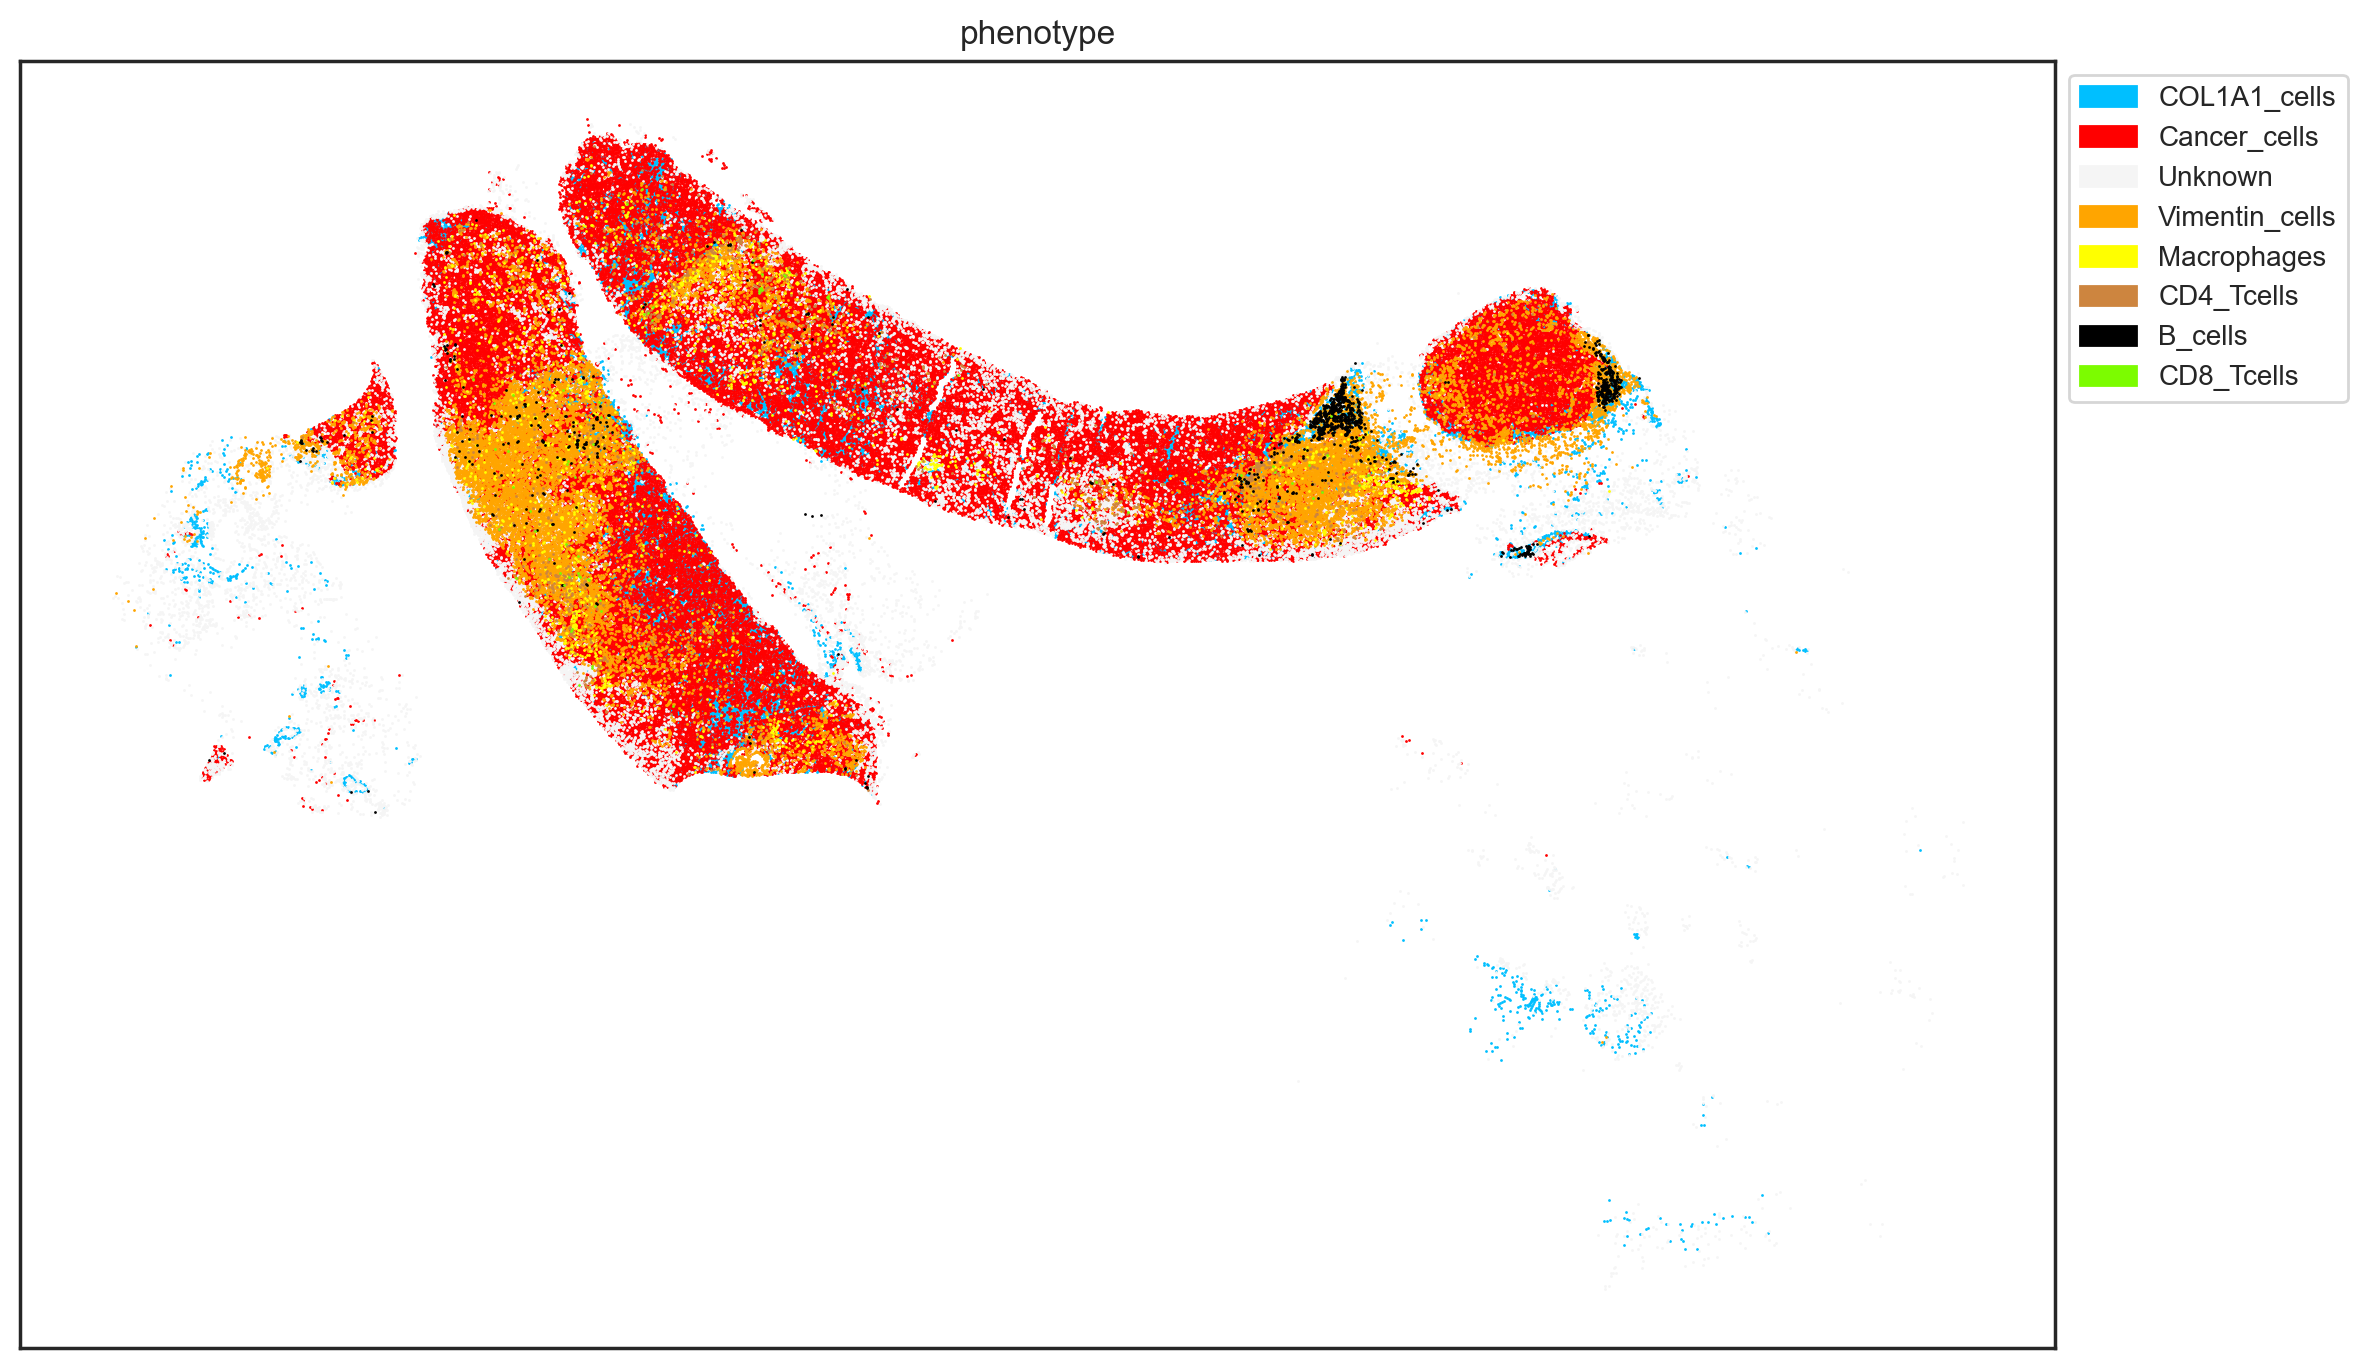

In [18]:
adata_copy = sm.tl.phenotype_cells (adata_copy, phenotype=phenotype_matrix, label="phenotype")
sm.pl.spatial_scatterPlot (adata_copy, colorBy = ['phenotype'],figsize=(12,7), s=1, fontsize=10, customColors=custom_colours)